In [1]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/DL/project/data/tomato")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, utils, models
import torchvision.utils as vutils

from google.colab import files
from IPython.display import Image
import time
from pylab import rcParams

from tensorflow import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
print (torch.cuda.device_count())

cuda:0
1


In [0]:
!pip install -q tf-nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [0]:
%load_ext tensorboard

In [0]:
# # Extract the dataset into the current directory
# if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
#     import zipfile
#     with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
#         archive.extractall()

## Data Augmentation 

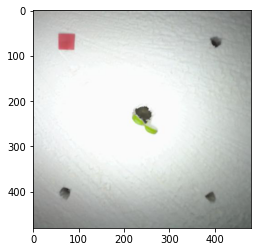

In [0]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/My Drive/DL/project/data/tomato/sep_data/train/1/1_ImageSet_Sep_18_08_27_12_4.jpg')
imgplot = plt.imshow(img)

In [0]:
def load_train_dataset(data_path, batch_size, num_workers):
    dataset = datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([#transforms.Resize(100),
                                      #transforms.CenterCrop(64),
                                      transforms.Resize((64, 64)),
                                      transforms.RandomAffine(20),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(45),
                                      transforms.ColorJitter(brightness=0.1, 
                                                             contrast=0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])
                                      ])
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    return loader

def load_val_dataset(data_path, batch_size, num_workers):
    dataset = datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([#transforms.Resize(100),
                                      #transforms.CenterCrop(64),
                                      transforms.Resize((64, 64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])
                                      ])
    )
  
    loader = torch.utils.data.DataLoader( 
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    return loader

In [3]:
train_root = '/content/drive/My Drive/DL/project/data/tomato/sep_data/train'
val_root = '/content/drive/My Drive/DL/project/data/tomato/sep_data/val'

train_root_weed = '/content/drive/My Drive/DL/project/data/weeds/Train'#sep_weed/train'
val_root_weed = '/content/drive/My Drive/DL/project/data/weeds/Test'#sep_weed/val'

batch_size = 128
num_workers = 4

%time train_data_loader = load_train_dataset(train_root_weed, batch_size, num_workers)
%time val_data_loader = load_val_dataset(val_root_weed, batch_size, num_workers)

CPU times: user 21.6 ms, sys: 1.63 ms, total: 23.3 ms
Wall time: 82.5 ms
CPU times: user 5.87 ms, sys: 4.81 ms, total: 10.7 ms
Wall time: 32.8 ms


torch.Size([128, 3, 64, 64])


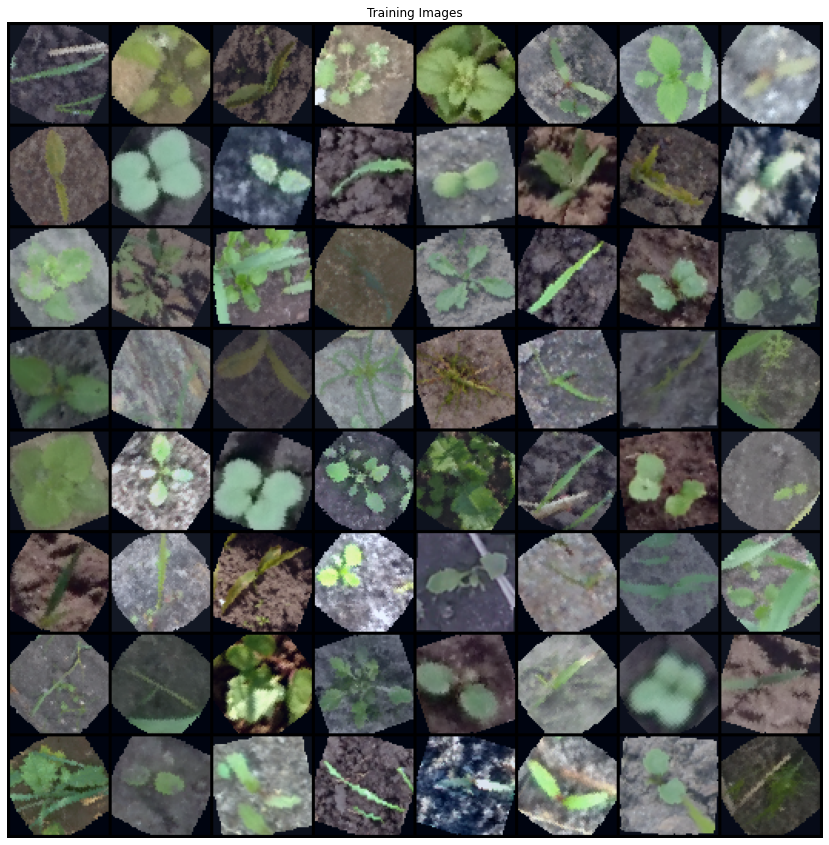

In [0]:
batch = next(iter(train_data_loader))
print (batch[0].shape)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model VGG16

In [0]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        layers = []
        in_channels = 3
        cfg = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']
        for l in cfg:
            if l == 'MP':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, l, kernel_size=3, padding=1),
                            nn.BatchNorm2d(l),
                            nn.ReLU(inplace=True)]
                in_channels = l
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 9),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight.data)

In [0]:
net = VGG16()

if torch.cuda.is_available():
    net = net.cuda()
    net = nn.DataParallel(net, device_ids=list(range(1)), output_device=device)
else:
    net = net.cpu()
    
net.apply(weights_init)

DataParallel(
  (module): VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding

In [0]:
#criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adadelta(net.parameters(), lr=1e-1, rho=0.95, eps=1e-8,
#                           weight_decay=5e-4)

def get_accuracy(outputs, labels):
    _, argmax = torch.max(outputs, 1)
    return (labels == argmax.squeeze()).float().mean()

def save_checkpoint(state, is_best, filename=''):
    if is_best:
        filename = filename+'model_best.pth.tar'        
        torch.save(state, filename)

In [0]:
def train(epoch, globaliter):
    net.train()
    running_loss = 0.
    running_accuracy = 0.
    # globaliter = 0
    
    for batch_idx, data in enumerate(train_data_loader):
        globaliter += 1
        images, labels = data[0].type(torch.FloatTensor), data[1]
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        accuracy = get_accuracy(outputs, labels).item()
        running_accuracy += accuracy
        loss = criterion(outputs, labels)
        with train_summary_writer.as_default():
            summary.scalar('loss', loss.item(), step=globaliter)
            summary.scalar('accuracy', accuracy, step=globaliter)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    running_accuracy /= len(train_data_loader)
    running_loss /= len(train_data_loader)
    print('Train set: Loss: {:.4f}, Accuracy: {:.2f}%)'.format(
        running_loss, 100 * running_accuracy))
    running_loss = 0.
    running_accuracy = 0.
    net.train()

    return running_loss, running_accuracy, globaliter

In [0]:
def valid(globaliter):
    net.eval()
    valid_loss = 0.
    valid_accuracy = 0.
    correct = 0
    with torch.no_grad():
        for data in val_data_loader:
            images, labels = data[0].type(torch.FloatTensor), data[1]
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            valid_loss += criterion(outputs, labels).item()
            valid_accuracy += get_accuracy(outputs, labels).item()
    valid_loss /= len(val_data_loader)
    valid_accuracy /= len(val_data_loader)
    print('Test set: Loss: {:.4f}, Accuracy: {:.2f}%)'.format(
        valid_loss, 100 * valid_accuracy))
    print('___________\n')
    with test_summary_writer.as_default():
          summary.scalar('loss', valid_loss, step=globaliter)
          summary.scalar('accuracy', valid_accuracy, step=globaliter)
    return valid_loss, valid_accuracy

In [7]:
import datetime
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

# %load_ext tensorboard
%tensorboard --logdir logs
# %tensorboard --logdir logs/tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [0]:
def initialize_model(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        models_list = []
        model_ft = models.alexnet()
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        models_list.append(model_ft)

    elif model_name == "resnet":

        models_list = []
        for model in (torchvision.models.resnet18, torchvision.models.resnet34, torchvision.models.resnet50, torchvision.models.resnet101, models.resnet152):
          model_ft = model()
          num_ftrs = model_ft.fc.in_features
          model_ft.fc = nn.Linear(num_ftrs, num_classes)
          models_list.append(model_ft)


    elif model_name == "vgg":
        models_list = []
        for model in (models.vgg11, models.vgg11_bn, models.vgg13, models.vgg13_bn, models.vgg16, models.vgg16_bn, models.vgg19_bn):
          model_ft = model()
          num_ftrs = model_ft.classifier[-1].in_features
          model_ft.classifier[-1] = nn.Linear(num_ftrs,num_classes)
          models_list.append(model_ft)
        
    elif model_name == "squeezenet":

        models_list = []
        for model in (torchvision.models.squeezenet1_0, torchvision.models.squeezenet1_1):
          model_ft = model()
          model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
          model_ft.num_classes = num_classes
          models_list.append(model_ft)

    elif model_name == "densenet":

        models_list = []
        for model in (torchvision.models.densenet121, torchvision.models.densenet169, torchvision.models.densenet161, models.densenet201):
          model_ft = model()
          num_ftrs = model_ft.classifier.in_features
          model_ft.classifier = nn.Linear(num_ftrs, num_classes)
          models_list.append(model_ft)

    elif model_name == "inception":
        models_list = []
        model_ft = models.inception_v3()
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        models_list.append(model_ft)

    elif model_name == "resnext":
      
      models_list = []
      for model in (models.resnext50_32x4d, models.resnext101_32x8d):
          model_ft = model()
          num_ftrs = model_ft.fc.in_features
          model_ft.fc = nn.Linear(num_ftrs,num_classes)
          models_list.append(model_ft)

    elif model_name == "wide_resnet":
      
      models_list = []
      for model in (torchvision.models.wide_resnet50_2, torchvision.models.wide_resnet101_2):
          model_ft = model()
          num_ftrs = model_ft.fc.in_features
          model_ft.fc = nn.Linear(num_ftrs,num_classes)
          models_list.append(model_ft)

    return models_list

In [14]:
models_list = []
models_list = initialize_model("resnext", 9) + initialize_model("wide_resnet", 9)# + initialize_model("alexnet", 9)# + initialize_model("inception", 9) +

for lr in (0.01, 0.005, 0.001):
    for i, model in enumerate(models_list):
      #print(model)
      net = model
      net = net.cuda()
      #net = nn.DataParallel(net, device_ids=list(range(1)), output_device=device)
    
      criterion = nn.CrossEntropyLoss().to(device)
      #optimizer = optim.Adadelta(net.parameters(), lr=1e-1, rho=0.95, eps=1e-8, weight_decay=5e-4)    
      optimizer = optim.Adam(net.parameters(), lr=lr)
      #net.apply(weights_init)
      DO_TRAIN = True
      if DO_TRAIN:
          epochs = 25
          best_accuracy = 0
          _time = time.time()
          globaliter = 0
    
          for epoch in range(1, epochs+1):
              print("Epoch:", epoch)
              running_loss, running_accuracy, globaliter = train(epoch, globaliter)
              print("Time:", time.time() - _time, '\n')
              if (epoch % 1 == 0):
                  #print('___________')
                  #print("Validation:")
                  loss, accuracy = valid(globaliter)
                  if accuracy > best_accuracy:
                      best_accuracy = accuracy
                      is_best = True
                  else:
                      is_best = False
                  save_checkpoint({
                      'epoch': epoch,
                      'state_dict': net.state_dict(),
                      'best_prec1': accuracy,
                      'optimizer': optimizer.state_dict(),
                  }, is_best, filename = net.__class__.__name__+str(i)+str(lr))
          print("Best ", best_accuracy, "lr ", lr)


Epoch: 1
Train set: Loss: 3.3591, Accuracy: 29.29%)
Time: 28.89945077896118 

Test set: Loss: 6.3756, Accuracy: 42.59%)
___________

Epoch: 2
Train set: Loss: 1.8705, Accuracy: 35.17%)
Time: 66.70335340499878 

Test set: Loss: 1.6715, Accuracy: 42.65%)
___________

Epoch: 3
Train set: Loss: 1.7413, Accuracy: 38.42%)
Time: 104.08476519584656 

Test set: Loss: 1.6536, Accuracy: 43.24%)
___________

Epoch: 4
Train set: Loss: 1.6703, Accuracy: 40.17%)
Time: 141.8003261089325 

Test set: Loss: 1.5470, Accuracy: 49.56%)
___________

Epoch: 5
Train set: Loss: 1.6100, Accuracy: 43.68%)
Time: 180.03676843643188 

Test set: Loss: 1.7133, Accuracy: 49.02%)
___________

Epoch: 6
Train set: Loss: 1.5649, Accuracy: 45.20%)
Time: 218.35231137275696 

Test set: Loss: 1.5582, Accuracy: 48.61%)
___________

Epoch: 7
Train set: Loss: 1.5049, Accuracy: 47.32%)
Time: 256.53281354904175 

Test set: Loss: 1.4468, Accuracy: 50.40%)
___________

Epoch: 8
Train set: Loss: 1.4871, Accuracy: 47.41%)
Time: 294.756

In [16]:
models_list[3]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
!gsutil -q -m cp /content/ResNet00.001model_best.pth.tar /content/drive/My\ Drive/

In [10]:
#Training wideresnet101 a bit more 
models_list = initialize_model("resnext", 9) + initialize_model("wide_resnet", 9)# + initialize_model("alexnet", 9)# + initialize_model("inception", 9) +
net = models_list[3]
checkpoint = torch.load('/content/ResNet30.001model_best.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
net.cuda()
#optimizer.load_state_dict(checkpoint['optimizer'])
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
#net.apply(weights_init)
DO_TRAIN = True
if DO_TRAIN:
            epochs = 15
            best_accuracy = 0
            _time = time.time()
            globaliter = 0
      
            for epoch in range(1, epochs+1):
                print("Epoch:", epoch)
                running_loss, running_accuracy, globaliter = train(epoch, globaliter)
                print("Time:", time.time() - _time, '\n')
                if (epoch % 1 == 0):
                    #print('___________')
                    #print("Validation:")
                    loss, accuracy = valid(globaliter)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        is_best = True
                    else:
                        is_best = False
                    save_checkpoint({
                        'epoch': epoch,
                        'state_dict': net.state_dict(),
                        'best_prec1': accuracy,
                        'optimizer': optimizer.state_dict(),
                    }, is_best, filename = net.__class__.__name__+"101")
            print("Best ", best_accuracy, "lr ", lr)

Epoch: 1
Train set: Loss: 0.9927, Accuracy: 63.12%)
Time: 39.66186761856079 

Test set: Loss: 0.9275, Accuracy: 66.60%)
___________

Epoch: 2
Train set: Loss: 0.9561, Accuracy: 63.90%)
Time: 95.17110133171082 

Test set: Loss: 1.0074, Accuracy: 63.19%)
___________

Epoch: 3
Train set: Loss: 0.9464, Accuracy: 64.27%)
Time: 145.02826523780823 

Test set: Loss: 0.9623, Accuracy: 65.34%)
___________

Epoch: 4
Train set: Loss: 0.9318, Accuracy: 64.63%)
Time: 194.3974118232727 

Test set: Loss: 0.9384, Accuracy: 67.09%)
___________

Epoch: 5
Train set: Loss: 0.9281, Accuracy: 65.15%)
Time: 249.41604852676392 

Test set: Loss: 0.9680, Accuracy: 64.95%)
___________

Epoch: 6
Train set: Loss: 0.9204, Accuracy: 65.29%)
Time: 298.9024956226349 

Test set: Loss: 1.0166, Accuracy: 63.88%)
___________

Epoch: 7
Train set: Loss: 0.9103, Accuracy: 65.36%)
Time: 347.7651138305664 

Test set: Loss: 1.0927, Accuracy: 61.90%)
___________

Epoch: 8
Train set: Loss: 0.8889, Accuracy: 66.16%)
Time: 396.88341

NameError: ignored

In [0]:
models_list = initialize_model("vgg", 9)

In [0]:
for i, model in enumerate(models_list):
  print(model)
  net = model
  net = net.cuda()
  #net = nn.DataParallel(net, device_ids=list(range(1)), output_device=device)

  criterion = nn.CrossEntropyLoss().to(device)
  #optimizer = optim.Adadelta(net.parameters(), lr=1e-1, rho=0.95, eps=1e-8, weight_decay=5e-4)    
  optimizer = optim.Adam()
  #net.apply(weights_init)
  DO_TRAIN = True
  if DO_TRAIN:
      epochs = 1
      best_accuracy = 0
      _time = time.time()
      globaliter = 0

      for epoch in range(1, epochs+1):
          print("Epoch:", epoch)
          running_loss, running_accuracy, globaliter = train(epoch, globaliter)
          print("Time:", time.time() - _time, '\n')
          if (epoch % 1 == 0):
              print('___________')
              print("Validation:")
              loss, accuracy = valid(globaliter)
              if accuracy > best_accuracy:
                  best_accuracy = accuracy
                  is_best = True
              else:
                  is_best = False
              save_checkpoint({
                  'epoch': epoch,
                  'state_dict': net.state_dict(),
                  'best_prec1': accuracy,
                  'optimizer': optimizer.state_dict(),
              }, is_best, filename = net.__class__.__name__+str(i))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

RuntimeError: ignored

In [0]:
DO_TRAIN = True
if DO_TRAIN:
    epochs = 50
    best_accuracy = 0
    _time = time.time()
    globaliter = 0

    for epoch in range(1, epochs+1):
        print("Epoch:", epoch)
        running_loss, running_accuracy, globaliter = train(epoch, globaliter)
        print("Time:", time.time() - _time, '\n')
        if (epoch % 5 == 0):
            print('___________')
            print("Validation:")
            loss, accuracy = valid(globaliter)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                is_best = True
            else:
                is_best = False
            save_checkpoint({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'best_prec1': accuracy,
                'optimizer': optimizer.state_dict(),
            }, is_best)

Epoch: 1
Train set: Loss: 2.0614, Accuracy: 33.85%)
Time: 876.4419000148773 

Epoch: 2
Train set: Loss: 1.6351, Accuracy: 44.19%)
Time: 924.041846036911 

Epoch: 3
Train set: Loss: 1.5096, Accuracy: 47.15%)
Time: 971.0377628803253 

Epoch: 4
Train set: Loss: 1.4434, Accuracy: 49.51%)
Time: 1018.9227519035339 

Epoch: 5
Train set: Loss: 1.4050, Accuracy: 50.29%)
Time: 1067.6253635883331 

___________
Validation:
Test set: Loss: 1.3394, Accuracy: 52.47%)
___________

Epoch: 6
Train set: Loss: 1.3573, Accuracy: 52.22%)
Time: 1320.50790143013 

Epoch: 7
Train set: Loss: 1.3242, Accuracy: 52.46%)
Time: 1368.5587446689606 

Epoch: 8
Train set: Loss: 1.3029, Accuracy: 53.56%)
Time: 1416.3314905166626 

Epoch: 9
Train set: Loss: 1.2755, Accuracy: 54.32%)
Time: 1463.4076027870178 

Epoch: 10
Train set: Loss: 1.2419, Accuracy: 55.48%)
Time: 1511.3106532096863 

___________
Validation:
Test set: Loss: 1.1667, Accuracy: 57.08%)
___________

Epoch: 11
Train set: Loss: 1.2370, Accuracy: 55.50%)
Time